In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pymysql
import getpass
import matplotlib.pyplot as plt
import statsmodels.api as sm

pd.set_option('display.max_rows', 500)
%matplotlib inline
sns.set()
sns.set_style("ticks")

In [2]:
pw = getpass.getpass()

········


In [3]:
conn = pymysql.connect(host="localhost",
                       port=3306,
                       user="ironhack",
                       passwd=pw,
                       db="olist")

# Analyzing relationship between sales and review score for product

In [4]:
product_review_query = """
WITH dedup_reviews AS (
    SELECT
        order_id,
        MAX(review_score)               AS review_score
    FROM order_reviews
    GROUP BY 1)

SELECT
    oi.product_id,
    COUNT(1)                AS purchases,
    AVG(dr.review_score)    AS avg_review_score,
    AVG(oi.price)           AS avg_price
FROM order_items oi
    JOIN dedup_reviews dr
    ON oi.order_id = dr.order_id
GROUP BY 1;
"""

product_review = pd.read_sql(product_review_query, conn)

Can we see any indication that product with higher ratings were purchased more frequently?

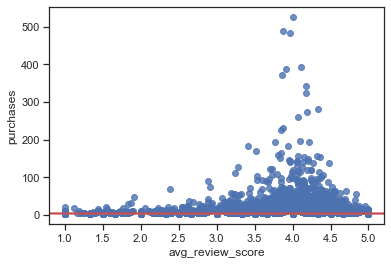

In [5]:
sns.regplot(data=product_review,
            x="avg_review_score",
            y="purchases",
            line_kws={"color": "r"});

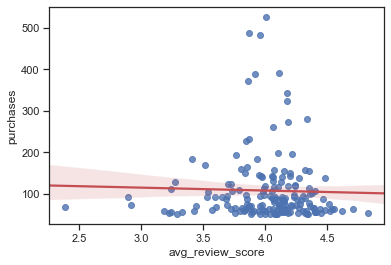

In [6]:
sns.regplot(data=product_review[product_review["purchases"] >= 50],
            x="avg_review_score",
            y="purchases",
            line_kws={"color": "r"});

Data does not suggest positive relationship between higher reviews and higher purchases of given products.

Maybe there is an omitted variable bias in the data. It's possible that products with higher prices tend to get lower ratings and are getting purchased less.

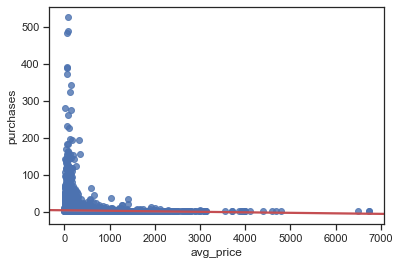

In [7]:
sns.regplot(data=product_review,
            x="avg_price",
            y="purchases",
            line_kws={"color": "r"});

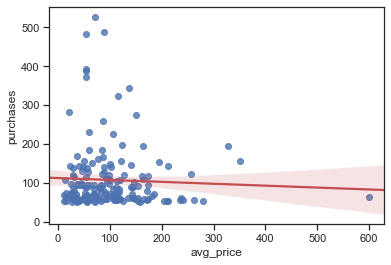

In [8]:
sns.regplot(data=product_review[product_review["purchases"] >= 50],
            x="avg_price",
            y="purchases",
            line_kws={"color": "r"});

These datapoints point into that direction.
We can try to isolate these effects by combining them into a linear regression model

In [9]:
# add constant
product_review = sm.add_constant(product_review)

y = product_review["purchases"]
X = product_review[["const", "avg_review_score", "avg_price"]]

purchases_lr = sm.OLS(y, X).fit()
purchases_lr.summary()

/Users/at/miniconda3/envs/day1/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              purchases   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     17.35
Date:                Tue, 12 Nov 2019   Prob (F-statistic):           2.94e-08
Time:                        21:03:56   Log-Likelihood:            -1.2459e+05
No. Observations:               32951   AIC:                         2.492e+05
Df Residuals:                   32948   BIC:                         2.492e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.7733      0.205     18.444      0.000       3.372       4.174
avg_review_score    -0.0380      0.048     -0.796      0.426      -0.132       0.056
avg_price           -0.0014      0.000     -5.844      0.000      -0.002      -0.001
==============================================================================
Omnibus:                    74888.602   Durbin-Watson:                   1.698
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        761746539.775
Skew:                          21.721   Prob(JB):                         0.00
Kurtosis:                     746.595   Cond. No.                     1.03e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
y_f = product_review[product_review["purchases"] >= 50]["purchases"]
X_f = product_review[product_review["purchases"] >= 50][["const", "avg_review_score", "avg_price"]]

purchases_lr_f = sm.OLS(y_f, X_f).fit()
purchases_lr_f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              purchases   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.2231
Date:                Tue, 12 Nov 2019   Prob (F-statistic):              0.800
Time:                        21:03:56   Log-Likelihood:                -1013.9
No. Observations:                 174   AIC:                             2034.
Df Residuals:                     171   BIC:                             2043.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              137.1876     73.260      1.873      0.063      -7.422     281.798
avg_review_score    -6.2910     18.185     -0.346      0.730     -42.188      29.606
avg_price           -0.0469      0.086     -0.544      0.587      -0.217       0.123
==============================================================================
Omnibus:                      128.025   Durbin-Watson:                   1.557
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              866.500
Skew:                           2.894   Prob(JB):                    6.95e-189
Kurtosis:                      12.274   Cond. No.                     1.47e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

No indication whatsoever...

So far we haven't found any evidence that positive ratings actually influence sales. However we looked at historical data, so deeper analysis might be required that looks at trends over time.
One major flaw of this analysis is that we used order reviews and assigned them to the order_item level which may not be related at all. Depending on what the review score reflects, the data used for this analysis might not be suitable. 

Instead, customers may exclusively review the olist service in their rating decision. There might be a general olist review that helps both customers and sellers make the decision if they either want to purchase products on olist or sell products, respectively. 

That said, the company decided that improving the reviews is the current goal of the quarter.

We've already established that delivery time, or to be more precise, the fact that customers receive orders prior to the estimate positively correlates with reviews. With that in mind, we want to see if giving more conservatives, that is, estimate the delivery further in the future might result in higher review scores.

So, before we run experiments, we want to analyze some data to inform where we could best perform some tweaks to potentially improve ratings.

In [11]:
ratings_query = """
WITH dedup_reviews AS (
    SELECT
        order_id,
        MAX(review_score)               AS review_score,
        MAX(review_answer_timestamp)    AS review_answer_timestamp
    FROM order_reviews
    GROUP BY 1)

SELECT
    o.order_id,
    ore.review_score,
    o.order_purchase_timestamp,
    o.order_estimated_delivery_date,
    o.order_delivered_customer_date,
    ore.review_answer_timestamp
FROM orders o
    JOIN order_reviews ore
    ON o.order_id = ore.order_id
WHERE 
    o.order_status = "delivered"
    AND o.order_delivered_customer_date > o.order_purchase_timestamp
"""

ratings = pd.read_sql(ratings_query, conn)

In [12]:
ratings.head()

,order_id,review_score,order_purchase_timestamp,order_estimated_delivery_date,order_delivered_customer_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,4,2017-10-02 10:56:33,2017-10-18,2017-10-10 21:25:13,2017-10-12 03:43:48
1,53cdb2fc8bc7dce0b6741e2150273451,4,2018-07-24 20:41:37,2018-08-13,2018-08-07 15:27:45,2018-08-08 18:37:50
2,47770eb9100c2d0c44946d9cf07ec65d,5,2018-08-08 08:38:49,2018-09-04,2018-08-17 18:06:29,2018-08-22 19:07:58
3,949d5b44dbf5de918fe9c16f97b45f8a,5,2017-11-18 19:28:06,2017-12-15,2017-12-02 00:28:42,2017-12-05 19:21:58
4,ad21c59c0840e6cb83a9ceb5573f8159,5,2018-02-13 21:18:39,2018-02-26,2018-02-16 18:17:02,2018-02-18 13:02:51


In [13]:
ratings.dtypes

order_id                                 object
review_score                              int64
order_purchase_timestamp         datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
order_delivered_customer_date    datetime64[ns]
review_answer_timestamp          datetime64[ns]
dtype: object

## 1. Distribution of review_score

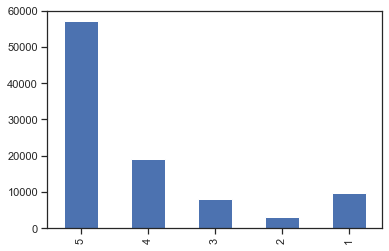

In [14]:
ratings["review_score"].value_counts().sort_index(ascending=False).plot(kind="bar");

In [15]:
ratings["review_score"].value_counts(normalize=True).sort_index(ascending=False)

5    0.589061
4    0.196274
3    0.083046
2    0.031080
1    0.100539
Name: review_score, dtype: float64

In [16]:
ratings["review_score"].describe()

count    97007.000000
mean         4.142237
std          1.296559
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review_score, dtype: float64

On average, customers rate olist with 4.1.

More than half of the reviews are 5 (59%).

The least frequent rating is 2 (3%).

A rating of 1 is the third most frequent rating (10%).

## 2. Distribution of delivery days estimation

In [17]:
ratings = ratings.assign(delivery_days_estimation=(ratings["order_estimated_delivery_date"] - ratings["order_purchase_timestamp"]).dt.days)

In [18]:
delivery_days_freq = (ratings["delivery_days_estimation"]
                      .value_counts()
                      .to_frame()
                      .reset_index()
                      .rename(columns={"index": "delivery_days_estimation",
                                       "delivery_days_estimation": "orders"})
                      .sort_values("delivery_days_estimation", ascending=False))
delivery_days_freq.head()

,delivery_days_estimation,orders
97,155,1
92,149,1
82,146,1
96,140,1
81,116,1


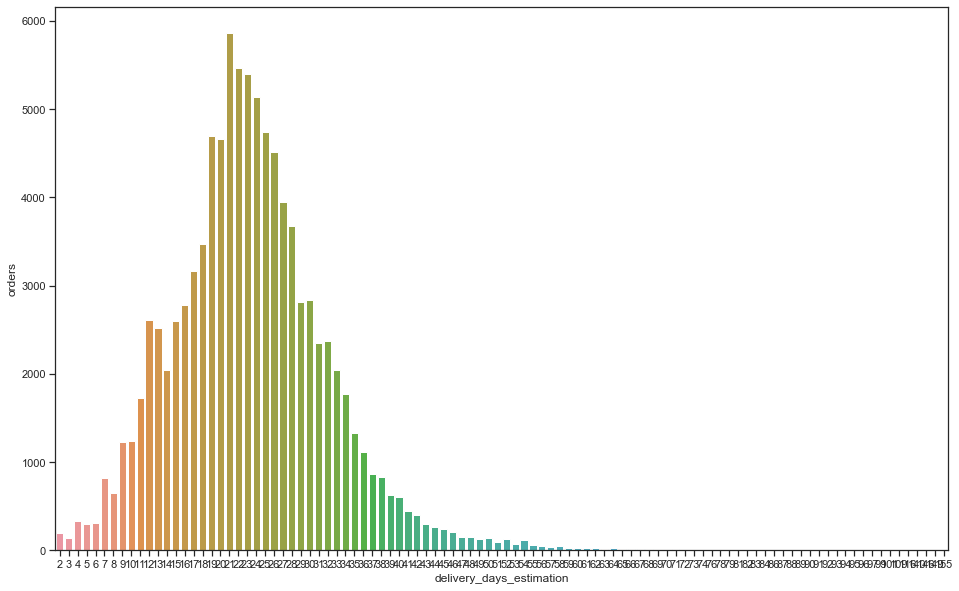

In [19]:
fig, ax = plt.subplots(figsize=(16,10))
sns.barplot(data=delivery_days_freq,
            x="delivery_days_estimation",
            y="orders",
            ax=ax);

In [20]:
ratings["delivery_days_estimation"].describe()

count    97007.000000
mean        23.383519
std          8.759589
min          2.000000
25%         18.000000
50%         23.000000
75%         28.000000
max        155.000000
Name: delivery_days_estimation, dtype: float64

Create a function to plot that distribution

In [21]:
def plot_datediff(df, start_date_col, end_date_col):
    dd_ser = (df[end_date_col] - df[start_date_col]).dt.days
    date_diff = (dd_ser
                 .value_counts()
                 .to_frame()
                 .sort_index()
                 .reset_index()
                 .rename(columns={"index": "days_between",
                                  0: "orders"}))
    
    fig, ax = plt.subplots(figsize=(16,8))
    sns.barplot(data=date_diff,
                x="days_between",
                y="orders",
                ax=ax);
    ax.axvline(dd_ser.mean(), color="g")
    ax.axvline(dd_ser.median(), color="r")
    
    print(dd_ser.describe())

count    97007.000000
mean        23.383519
std          8.759589
min          2.000000
25%         18.000000
50%         23.000000
75%         28.000000
max        155.000000
dtype: float64


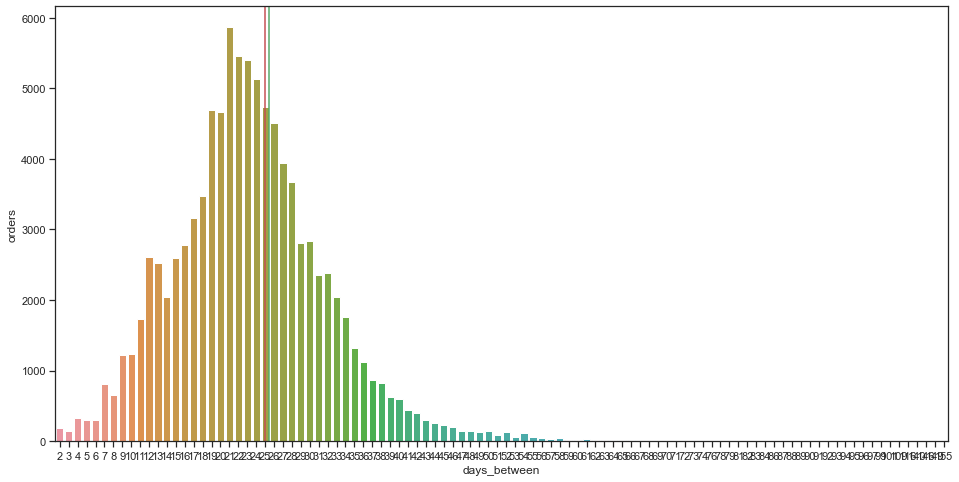

In [22]:
plot_datediff(ratings, "order_purchase_timestamp", "order_estimated_delivery_date")

We estimate no delivery faster than 2 days. On average, we estimate delivery to take 24 days. 75% of our customers should receive their delivery within 28 days.

## 3. Distribution of actual delivery days

count    97007.000000
mean        12.100044
std          9.547546
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
dtype: float64


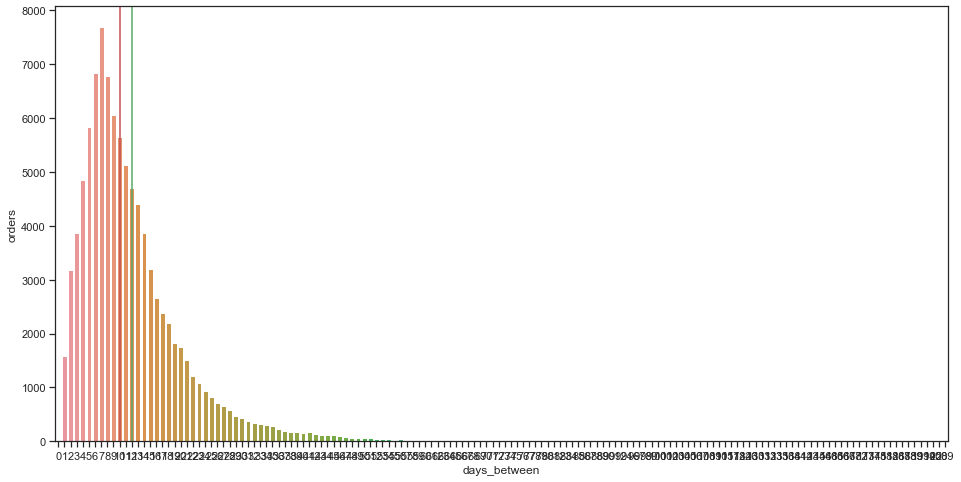

In [23]:
plot_datediff(ratings,
              "order_purchase_timestamp",
              "order_delivered_customer_date")

We actually had cases of same day delivery. On average, delivery takes 12 days. That is 12 days faster than we estimate on average (half the days). 

## 4. Distribution of difference between estimated and actual delivery days

count    97007.000000
mean       -11.880256
std         10.182600
min       -147.000000
25%        -17.000000
50%        -12.000000
75%         -7.000000
max        188.000000
dtype: float64


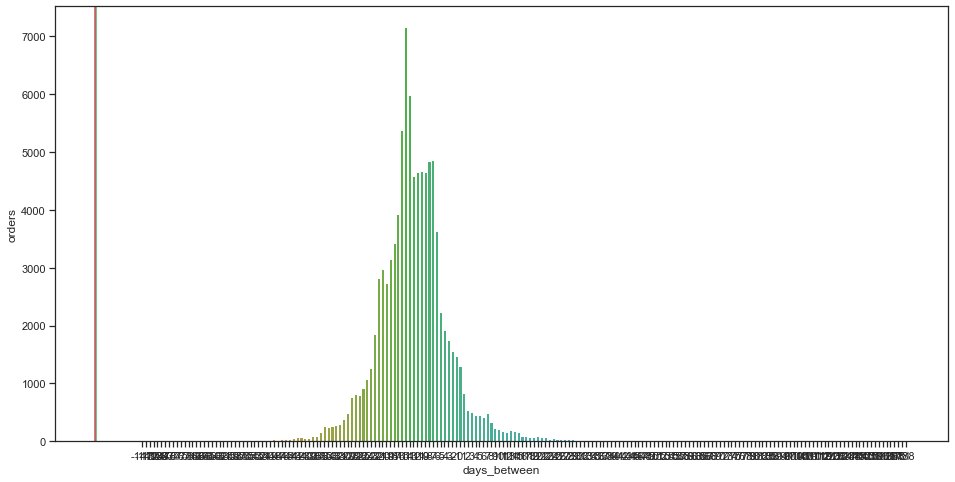

In [24]:
plot_datediff(ratings, "order_estimated_delivery_date", "order_delivered_customer_date")

As we can see from this view, on average, consumers receive their delivery 12 days earlier than estimated. 

## 5. Distribution of number of days btw order and review

count    97007.000000
mean        14.997990
std         12.314835
min        -77.000000
25%          9.000000
50%         13.000000
75%         19.000000
max        528.000000
dtype: float64


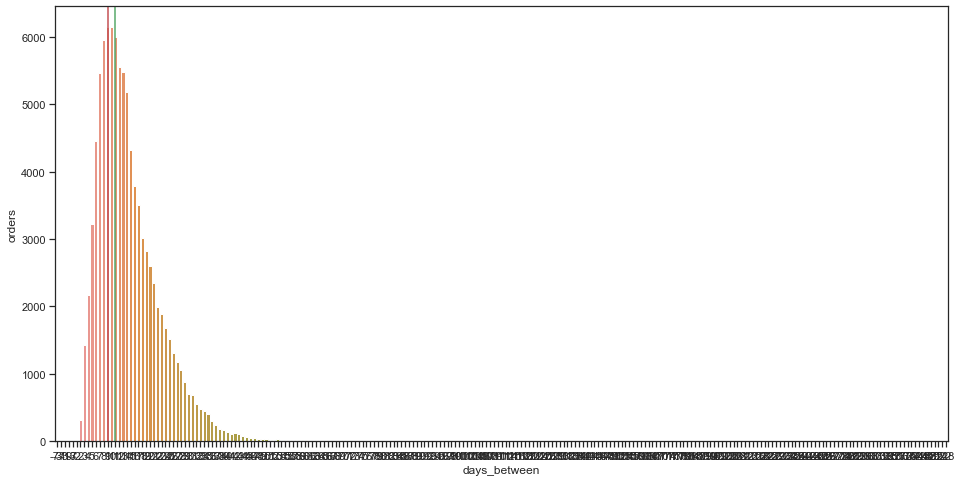

In [25]:
plot_datediff(ratings,
              "order_purchase_timestamp", 
              "review_answer_timestamp")